In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, ttest_1samp


In [68]:
df = pd.read_csv("/mnt/hdd/anatkorol/Imagination_in_translation/Data/processed_data/08092025_pilot/participants_log_with_gpt_with_distances_and_len_pilot_08092025_.csv")
df = df[['uid', 'gt', 'session', 'attempt', 'prompt', 'gen', 'subjective_score','clip_cosine_distance', 'vgg_fc7_distance','prompt_length', 'prompt_word_len']].copy()
df_ppt = df[df['uid'] != 'gpt-5'].copy()
df_gpt = df[df['uid'] == 'gpt-5'].copy()

In [46]:
pd.set_option('display.max_colwidth', None)
df['prompt']

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Hall
1                                                                                                                                                                                                                      

# Visualizing legnth of prompt by attempt

/tmp/ipykernel_2523941/144122527.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df_ppt, x="attempt", y="prompt_word_len", ci="sd", color="lightblue")


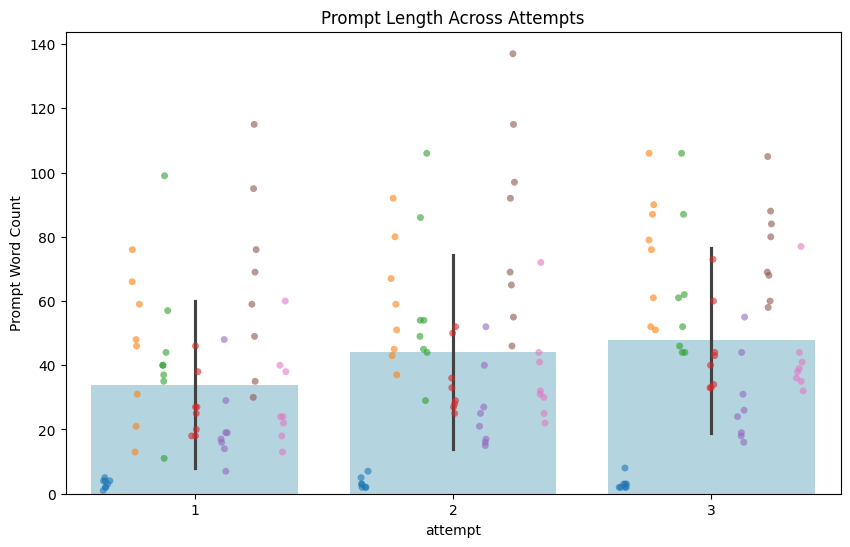

In [54]:
df_ppt_mean = df_ppt.groupby(["uid", "attempt"])["prompt_word_len"].mean().reset_index()
plt.figure(figsize=(10,6))
sns.barplot(data=df_ppt, x="attempt", y="prompt_word_len", ci="sd", color="lightblue")
sns.stripplot(data=df_ppt, x="attempt", y="prompt_word_len", hue="uid", alpha=0.6, jitter=True, dodge=True)
plt.ylabel("Prompt Word Count")
plt.title("Prompt Length Across Attempts")
plt.legend([],[], frameon=False)  #removing legend (info about ppt)
plt.show()

# Correlation between subjective and objective similarity scores 

In [74]:
# inverting cosine distance to similarity
df_ppt["clip_similarity"] = 1 - df_ppt["clip_cosine_distance"]
df_ppt['vgg_similarity'] = 1 - df_ppt['vgg_fc7_distance']
df_gpt["clip_similarity"] = 1 - df_gpt["clip_cosine_distance"]
df_gpt['vgg_similarity'] = 1 - df_gpt['vgg_fc7_distance']
df['clip_similarity'] = 1 - df['clip_cosine_distance']
df['vgg_similarity'] = 1 - df['vgg_fc7_distance']

## correlation between vgg and clip similarity

In [79]:
pearson_corr, pearson_p = pearsonr(df['clip_cosine_distance'], df['vgg_fc7_distance'])
print(f"Pearson correlation between CLIP and VGG distances: {pearson_corr:.3f} (p={pearson_p:.3f})")


Pearson correlation between CLIP and VGG distances: 0.173 (p=0.017)


## computing correlations between subjective and objective similarity scores - globally

In [ ]:
#computing correlation as if all data points are independent - but they are not!!
pearson_corr, pearson_p = pearsonr(df_ppt["subjective_score"], df_ppt["clip_similarity"])
print(f"Pearson correlation between subjective score and CLIP similarity: {pearson_corr:.3f} (p={pearson_p:.3f})")

Pearson correlation between subjective score and CLIP similarity: 0.189 (p=0.014)


In [65]:
pearson_corr, pearson_p = pearsonr(df_ppt["subjective_score"], df_ppt["vgg_similarity"])
print(f"Pearson correlation between subjective score and VGG fc7 similarity: {pearson_corr:.3f} (p={pearson_p:.3f})")

Pearson correlation between subjective score and VGG fc7 similarity: 0.169 (p=0.029)


## computing correlations between subjective and objective similarity scores - within participants

/tmp/ipykernel_2523941/3114396826.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=df_corr, x="measure", y="r", ci=None, color="lightblue")


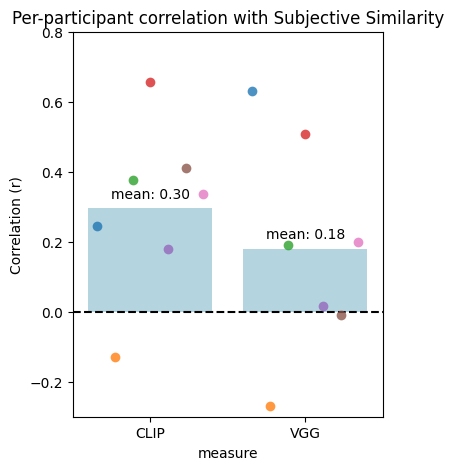

In [99]:
# Collect correlations per participant
corrs = []
for uid, subdf in df_ppt.groupby("uid"):
    r_clip, _ = pearsonr(subdf["subjective_score"], subdf["clip_similarity"])
    r_vgg, _ = pearsonr(subdf["subjective_score"], subdf["vgg_similarity"])
    corrs.append({"uid": uid, "measure": "CLIP", "r": r_clip})
    corrs.append({"uid": uid, "measure": "VGG", "r": r_vgg})

df_corr = pd.DataFrame(corrs)

# Compute means
means = df_corr.groupby("measure")["r"].mean().reset_index()

plt.figure(figsize=(4,5))
ax = sns.barplot(data=df_corr, x="measure", y="r", ci=None, color="lightblue")

# Add participant dots
sns.stripplot(data=df_corr, x="measure", y="r", hue="uid",
              dodge=True, jitter=False, size=7, alpha=0.8)

# Add horizontal line at 0
plt.axhline(0, color="black", linestyle="--")

# Add mean value labels
for i, row in means.iterrows():
    ax.text(i, row["r"] + 0.02, f"mean: {row['r']:.2f}", 
            ha='center', va='bottom', fontsize=10)

plt.ylabel("Correlation (r)")
plt.title("Per-participant correlation with Subjective Similarity")
plt.legend([],[], frameon=False)  # remove uid legend
plt.ylim(-0.3, 0.8)  # keep full r range visible
plt.show()


## measuring Mixed-effects regression 
* I don't understand it and I didn't report it for now*
* Treat subjective score as DV, and use clip/vgg similarity as predictors, with random intercepts for participants

In [100]:
import statsmodels.formula.api as smf

model = smf.mixedlm("subjective_score ~ vgg_similarity",
                    data=df_ppt, groups=df_ppt["uid"])
result = model.fit()
print(result.summary())


            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: subjective_score
No. Observations: 167     Method:             REML            
No. Groups:       7       Scale:              300.5667        
Min. group size:  23      Log-Likelihood:     -718.3776       
Max. group size:  24      Converged:          Yes             
Mean group size:  23.9                                        
---------------------------------------------------------------
                 Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept        29.996     9.064  3.309  0.001  12.232  47.760
vgg_similarity   30.097     9.258  3.251  0.001  11.953  48.242
Group Var       384.118    13.455                              



In [101]:
import statsmodels.formula.api as smf

model = smf.mixedlm("subjective_score ~ clip_similarity",
                    data=df_ppt, groups=df_ppt["uid"])
result = model.fit()
print(result.summary())


            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: subjective_score
No. Observations: 167     Method:             REML            
No. Groups:       7       Scale:              298.5118        
Min. group size:  23      Log-Likelihood:     -716.9690       
Max. group size:  24      Converged:          Yes             
Mean group size:  23.9                                        
--------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept        -10.133   18.117 -0.559 0.576 -45.641  25.376
clip_similarity   74.080   21.602  3.429 0.001  31.742 116.419
Group Var        382.562   13.446                             



# similarity scores per attempt - ppt df and gpt df

/tmp/ipykernel_2523941/2301638413.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df_mean, x="attempt", y="clip_similarity", ci="sd", color="lightblue")


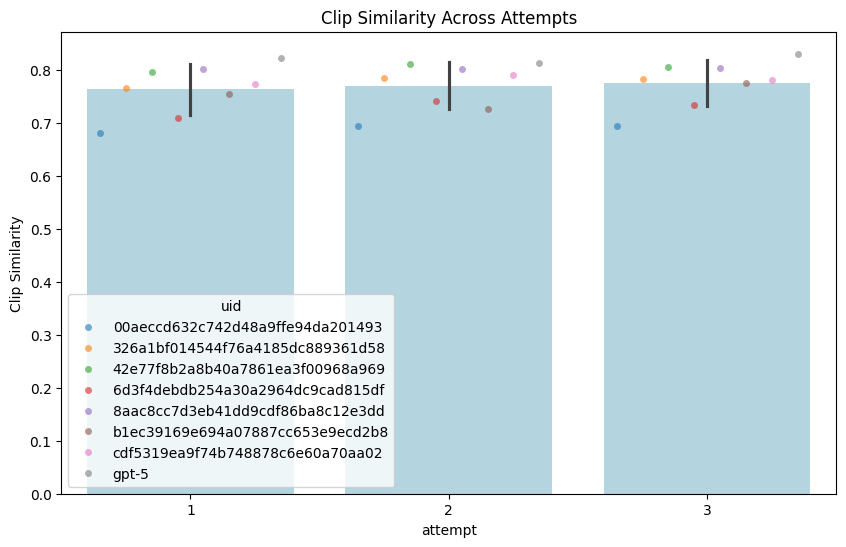

In [104]:
df_mean = df.groupby(["uid", "attempt"])["clip_similarity"].mean().reset_index()
plt.figure(figsize=(10,6))
sns.barplot(data=df_mean, x="attempt", y="clip_similarity", ci="sd", color="lightblue")
sns.stripplot(data=df_mean, x="attempt", y="clip_similarity", hue="uid", alpha=0.6, jitter=True, dodge=True)
plt.ylabel("Clip Similarity")
plt.title("Clip Similarity Across Attempts")
# plt.legend([],[], frameon=False)  #removing legend (info about ppt)
plt.show()

/tmp/ipykernel_2523941/1864953382.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df_ppt, x="session", y="clip_similarity", ci="sd", color="lightblue")


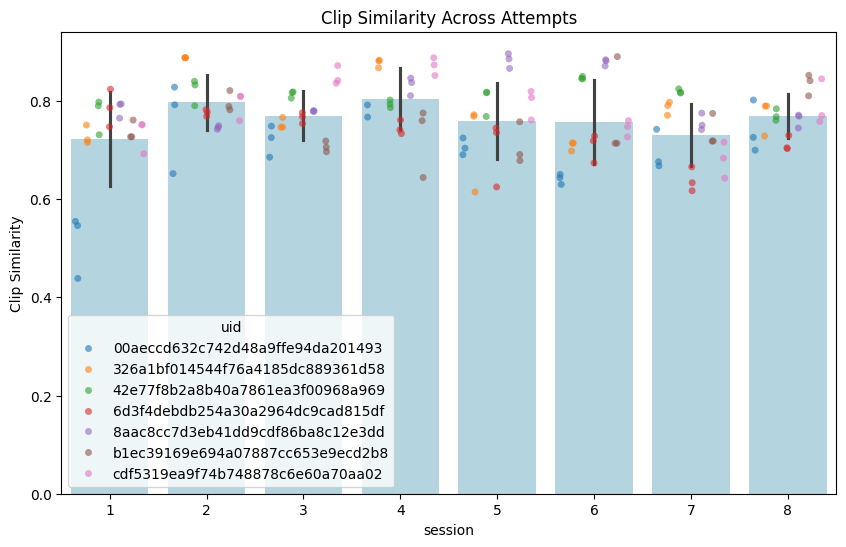

In [ ]:
#compute clip similarity for gpt
plt.figure(figsize=(10,6))
sns.barplot(data=df_ppt, x="attempt", y="clip_similarity", ci="sd", color="lightblue")
sns.stripplot(data=df_ppt, x="attempt", y="clip_similarity", hue="uid", alpha=0.6, jitter=True, dodge=True)
plt.ylabel("Clip Similarity")
plt.title("Clip Similarity Across Attempts")
# plt.legend([],[], frameon=False)  #removing legend (info about ppt)
plt.show()